In [273]:
import numpy as np
import random
import matplotlib.pyplot as plt
import numba
import time
import os
from datetime import datetime


In [274]:
def create_lattice(lattice_length, T_num, B_num):
    lattice = np.zeros([lattice_length, lattice_length])
    
    # Place T's randomly
    t_coords = np.empty((2, 0), dtype=int)  # Initialize as an empty array
    while t_coords.shape[1] < T_num:  # Check the number of columns
        t = np.array([[np.random.randint(lattice_length)], [np.random.randint(lattice_length)]])
        if not np.any(np.all(t == t_coords, axis=0)):
            t_coords = np.hstack((t_coords, t))
            lattice[t[0, 0], t[1, 0]] = 1
    
    # Place B's randomly
    b_coords = np.empty((2, 0), dtype=int)  # Initialize as an empty array
    while b_coords.shape[1] < B_num:  # Check the number of columns
        b = np.array([[np.random.randint(lattice_length)], [np.random.randint(lattice_length)]])
        if not np.any(np.all(b == b_coords, axis=0)) and not np.any(np.all(b == t_coords, axis=0)):
            b_coords = np.hstack((b_coords, b))
            lattice[b[0, 0], b[1, 0]] = 2
    
    empty_coords = np.argwhere(lattice == 0).T
    
    return lattice, t_coords, b_coords, empty_coords

In [275]:
# showing lattices as they evolve 

def lattice_plots(lattice_history, selected_indices):

    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

    for i in range(len(selected_indices)):

        # Create a plot
        plt.imshow(lattice_history[i], cmap=cmap, extent=[0, size, 0, size])
        plt.colorbar(ticks=[0, 1, 2], label="Legend")
        plt.title("Lattice with T's (Blue) and B's (Red)")

  

        #plt.title(f"Lattice at Iteration {selected_indices[i]}")  # Add a title with the iteration number

        #fig_name = f"Plot\Lattice_iter{selected_indices[i]}"
        # plt.savefig(fig_name)
        plt.show()
        

In [276]:
def position_random(pos): ###Problem
    col = np.random.randint(pos.shape[1]) ###REVIEW
    p = pos[:,col]
    #print("random",col,pos.shape[1]-1 )
    return p, col

In [277]:

def energy(lattice, ID_in, pos_hypo, interaction_matrix):
    s = lattice.shape[0]-1
    i = pos_hypo[0] # x coordinate
    j = pos_hypo[1] # y coordinate
    
    if i==0:
        up = lattice[s,j]   
    else:    
        up = lattice[i-1,j]
    up = int(up)

    if i == s:
        down = lattice[0,j]      
    else:
        down = lattice[i+1,j]
    down = int(down)

    if j == 0:
        left = lattice[i,s]        
    else:
        left = lattice[i,j-1]    
    left = int(left)

    if j == s:
        right = lattice[i,0]       
    else:
        right = lattice[i,j+1]
    right = int(right)
    
    
    E = -(interaction_matrix[ID_in, up] + interaction_matrix[ID_in, down] + interaction_matrix[ID_in, left] + 
          interaction_matrix[ID_in, right])
    return E

In [278]:
# total energy of lattice
def lattice_energy(lattice, eps):
    
    E_total = 0
    rows, cols = lattice.shape

    for i in range(rows):
        for j in range(cols):
            val = int(lattice[i, j])
            E_total += energy(lattice, val, (i, j), eps)

    E_total = E_total / 2
    
    return E_total


In [279]:
# check if object moves. pos1 is the coordinates of all objects where one is to be moved. 
# most likely a Tcell
# pos0 are coordinates of holes in the lattice 

def evaluate_particle_move(lattice, pos1, pos0, T, E_total, eps):
    #print("pos1before",pos1.shape)
    p1, col1 = position_random(pos1)
    
    ID_in = lattice[p1[0], p1[1]]
    ID_in = int(ID_in)
    Ein = energy(lattice,ID_in, p1, eps)
    
    p0, col0 = position_random(pos0)
    # seeing what energy would be for particle if it moved the the chosen empty location
    lattice[p1[0], p1[1]] = 0 # temporarily moving object so not to be seen as neighbor by itself
    Efin = energy(lattice, ID_in, p0, eps)
    #print("Efin , Ein", Efin, Ein)
    Ediff = Efin - Ein


    if Ediff < 0 :
        move = True
    
    else:
        probability = np.exp(-Ediff/T)
        if random.random() < probability: # random.random gives between 0 and 1. Hence higher prob -> more move
            move = True 
        else:
            move = False
        
    if move: 
        lattice[p0[0], p0[1]] = 1
        # update arrays containing coordinates of 0's and 1's
        pos1[:,col1] = [p0[0], p0[1]]
        pos0[:,col0] = [p1[0], p1[1]]
        E_total = E_total + Ediff
        E_total = float(E_total)
        print("Ediff:", Ediff)
        
    else:
        lattice[p0[0], p0[1]] = 0
        lattice[p1[0], p1[1]] = 1
    #print(E_total, Ediff)
    return lattice, pos1, pos0, E_total

In [280]:

def monte_carlo(T, eps, lattice_length, T_num, B_num, num_runs, num_lattices_to_store=None):
    lattice, pos1, b_coords, pos0 = create_lattice(lattice_length, T_num, B_num)
    E_lattice = lattice_energy(lattice, eps)
    print('E_in',E_lattice)
    # Create a colormap for red (B) and blue (T)
    cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

    # Plot the lattice
    plt.imshow(lattice, cmap=cmap, extent=[0, lattice_length, 0, lattice_length])
    plt.colorbar(ticks=[0, 1, 2], label="Legend")
    plt.title("Lattice with T's (Blue) and B's (Red)")
    #plt.grid(True, linewidth=0.5, color='black')
    plt.show()
    
    lattice_history = []
    E_history = []
    #for temperature in T:
    
    
    for i in range(0,num_runs): # change to from one and append initial E and lattice to outisde
        
        lattice, pos1, pos0, E_lattice = evaluate_particle_move(
                                         lattice, pos1, pos0, T, E_lattice, eps)
        #lattice_history.append(lattice.copy())
        #E_history.append(E_lattice.copy())
        #print(pos1, pos0)
        #print('E_after',E_lattice)
    #return lattice_history, E_history, T_num, B_num
    return lattice

E_in -1.0


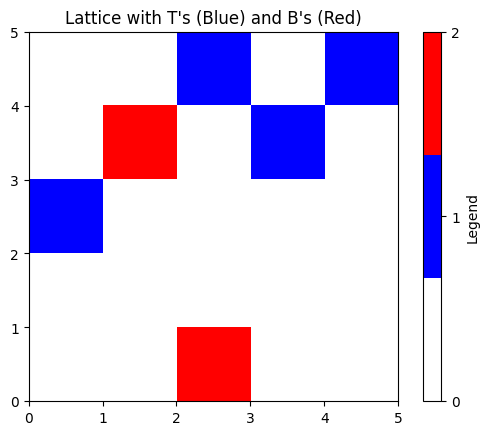

Ediff: -1
Ediff: 0
Ediff: 0
Ediff: 0
Ediff: -1
Ediff: 0
Ediff: 0
Ediff: 0


ValueError: too many values to unpack (expected 4)

In [281]:
# the interaction matrix can be used to decide how many bacteria are able to multiply. 
# if surrounded by T cells -> no division
# the body is modelled by an N by N lattice

num_runs = 10
Temp = 0.2

size = 5

T_num_in = 4    # number of initial T-cells
B_num_in = 2

BB_int = 0      # interaction energy between bacterias
TT_int = 0      # interaction energy between T-cells
BT_int = 1     # interaction energy between bacteria and T-cells
interaction_matrix = np.array([
    [0, 0, 0],
    [0, TT_int, BT_int],
    [0, BT_int, BB_int]
])

lattice, E_lattice, T_num, B_num = monte_carlo(
    Temp, interaction_matrix, size, T_num_in, B_num_in, num_runs, num_lattices_to_store=None)

#E_lattice

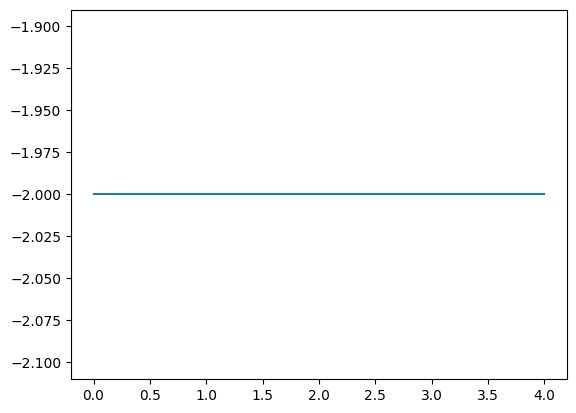

In [ ]:
plt.figure()
plt.plot(E_lattice)
plt.show()

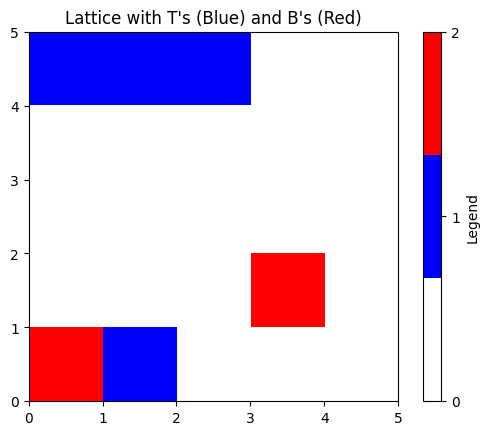

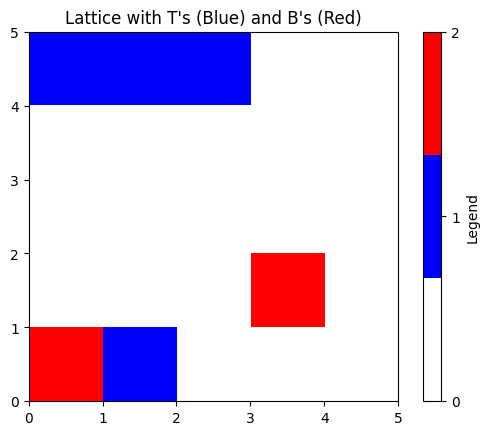

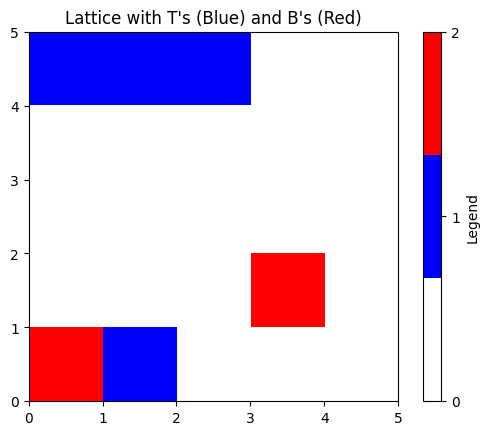

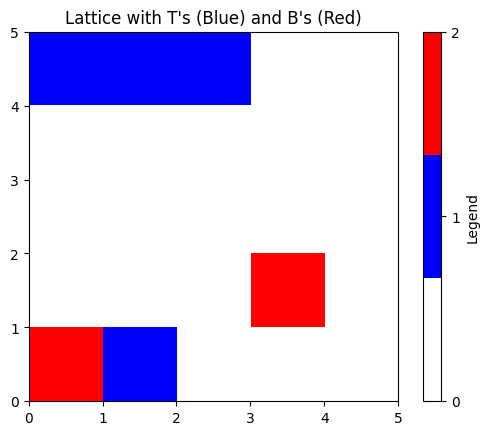

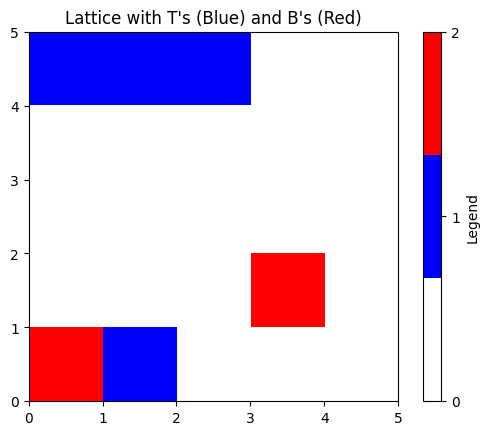

IndexError: list index out of range

In [ ]:
lattice_plots(lattice, np.arange(0,100,5))

TypeError: Invalid shape (20, 5, 5) for image data

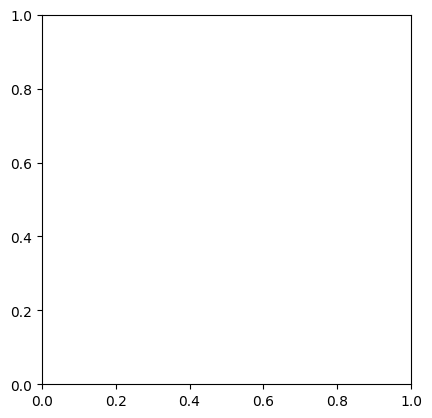

In [ ]:
# Create a colormap for red (B) and blue (T)
cmap = plt.cm.colors.ListedColormap(['white', 'blue', 'red'])

# Plot the lattice
plt.imshow(lattice, cmap=cmap, extent=[0, size, 0, size])
plt.colorbar(ticks=[0, 1, 2], label="Legend")
plt.title("Lattice with T's (Blue) and B's (Red)")
#plt.grid(True, linewidth=0.5, color='black')
plt.show()